# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки, зафиксируем рандомстейт.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [6]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42
COLORS = ('red', 'green', 'blue')
CMAPS = ('Reds', 'Greens', 'Blues')

### Загрузка данных

Считаем CSV-файлы с данными и сохраним их в список `regions`. В качестве индекса установим уникальный идентификатор скважины. Изучим общую информацию о датафреймах.

In [9]:
regions = []

for key in range(3):
    csv_local_path = f'datasets/geo_data_{key}.csv'
    csv_url = f'https://example.com/datasets/geo_data_{key}.csv'
    if os.path.exists(csv_local_path):
        region = pd.read_csv(csv_local_path, index_col='id')
    else:
        region = pd.read_csv(csv_url, index_col='id')
    regions.append(region)
    
    display(f'Регион {key}:')
    display(region.head())
    display(region.info())

'Регион 0:'

f0        f1        f2     product
id                                             
txEyH  0.705745 -0.497823  1.221170  105.280062
2acmU  1.334711 -0.340164  4.365080   73.037750
409Wp  1.022732  0.151990  1.419926   85.265647
iJLyR -0.032172  0.139033  2.978566  168.620776
Xdl7t  1.988431  0.155413  4.751769  154.036647

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

'Регион 1:'

f0         f1        f2     product
id                                               
kBEdx -15.001348  -8.276000 -0.005876    3.179103
62mP7  14.272088  -3.475083  0.999183   26.953261
vyE1P   6.263187  -5.948386  5.001160  134.766305
KcrkZ -13.081196 -11.506057  4.999415  137.945408
AHL4O  12.702195  -8.147433  5.004363  134.766305

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

'Регион 2:'

f0        f1        f2     product
id                                             
fwXo0 -1.146987  0.963328 -0.828965   27.758673
WJtFt  0.262778  0.269839 -2.530187   56.069697
ovLUW  0.194587  0.289035 -5.586433   62.871910
q6cA6  2.236060 -0.553760  0.930038  114.572842
WPMUX -0.515993  1.716266  5.899011  149.600746

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

Датафреймы с данными геологоразведки трёх регионов содержат:
- `index` — уникальный идентификатор скважины в качестве индекса;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

### Предобработка данных

Проверим дубликаты в индексах датафреймов (уникальный идентификатор скважины).

In [13]:
for key, region in enumerate(regions):
    display(f'Регион {key}: {region.index.duplicated().sum()}')

'Регион 0: 10'

'Регион 1: 4'

'Регион 2: 4'

Есть дубликаты в индексах. Удаляем.

In [15]:
for key, region in enumerate(regions):
    regions[key] = region[~region.index.duplicated()]

Проверим явные дубликаты в данных.

In [17]:
for key, region in enumerate(regions):
    display(f'Регион {key}: {region.duplicated().sum()}')

'Регион 0: 0'

'Регион 1: 0'

'Регион 2: 0'

Явных дубликатов в данных нет. Проверим пропуски.

In [19]:
for key, region in enumerate(regions):
    display(f'Регион {key}: {region.isna().sum().sum()}')

'Регион 0: 0'

'Регион 1: 0'

'Регион 2: 0'

Пропусков нет.

### Исследовательский анализ данных

Посмотрим на числовое описание количественных признаков в датафреймах из списка `regions`.

In [23]:
for key, region in enumerate(regions):
    display(f'Регион {key}:')
    display(region.describe().T)

'Регион 0:'

count       mean        std        min        25%        50%  \
f0       99990.0   0.500454   0.871844  -1.408605  -0.072572   0.502405   
f1       99990.0   0.250141   0.504430  -0.848218  -0.200877   0.250252   
f2       99990.0   2.502629   3.248149 -12.088328   0.287784   2.515969   
product  99990.0  92.499684  44.288304   0.000000  56.497069  91.847928   

                75%         max  
f0         1.073626    2.362331  
f1         0.700640    1.343769  
f2         4.715035   16.003790  
product  128.563699  185.364347

'Регион 1:'

count       mean        std        min        25%        50%  \
f0       99996.0   1.141209   8.965815 -31.609576  -6.298551   1.153055   
f1       99996.0  -4.796608   5.119906 -26.358598  -8.267985  -4.813172   
f2       99996.0   2.494501   1.703579  -0.018144   1.000021   2.011475   
product  99996.0  68.823916  45.944663   0.000000  26.953261  57.085625   

                75%         max  
f0         8.620964   29.421755  
f1        -1.332816   18.734063  
f2         3.999904    5.019721  
product  107.813044  137.945408

'Регион 2:'

count       mean        std        min        25%        50%  \
f0       99996.0   0.002002   1.732052  -8.760004  -1.162328   0.009424   
f1       99996.0  -0.002159   1.730397  -7.084020  -1.174841  -0.009661   
f2       99996.0   2.495084   3.473482 -11.970335   0.130269   2.484236   
product  99996.0  94.998342  44.749573   0.000000  59.450028  94.925026   

                75%         max  
f0         1.158477    7.238262  
f1         1.163523    7.844801  
f2         4.858720   16.739402  
product  130.586815  190.029838

Изучим распределения количественных признаков в датафреймах из списка `regions`.

'Регион 0:'

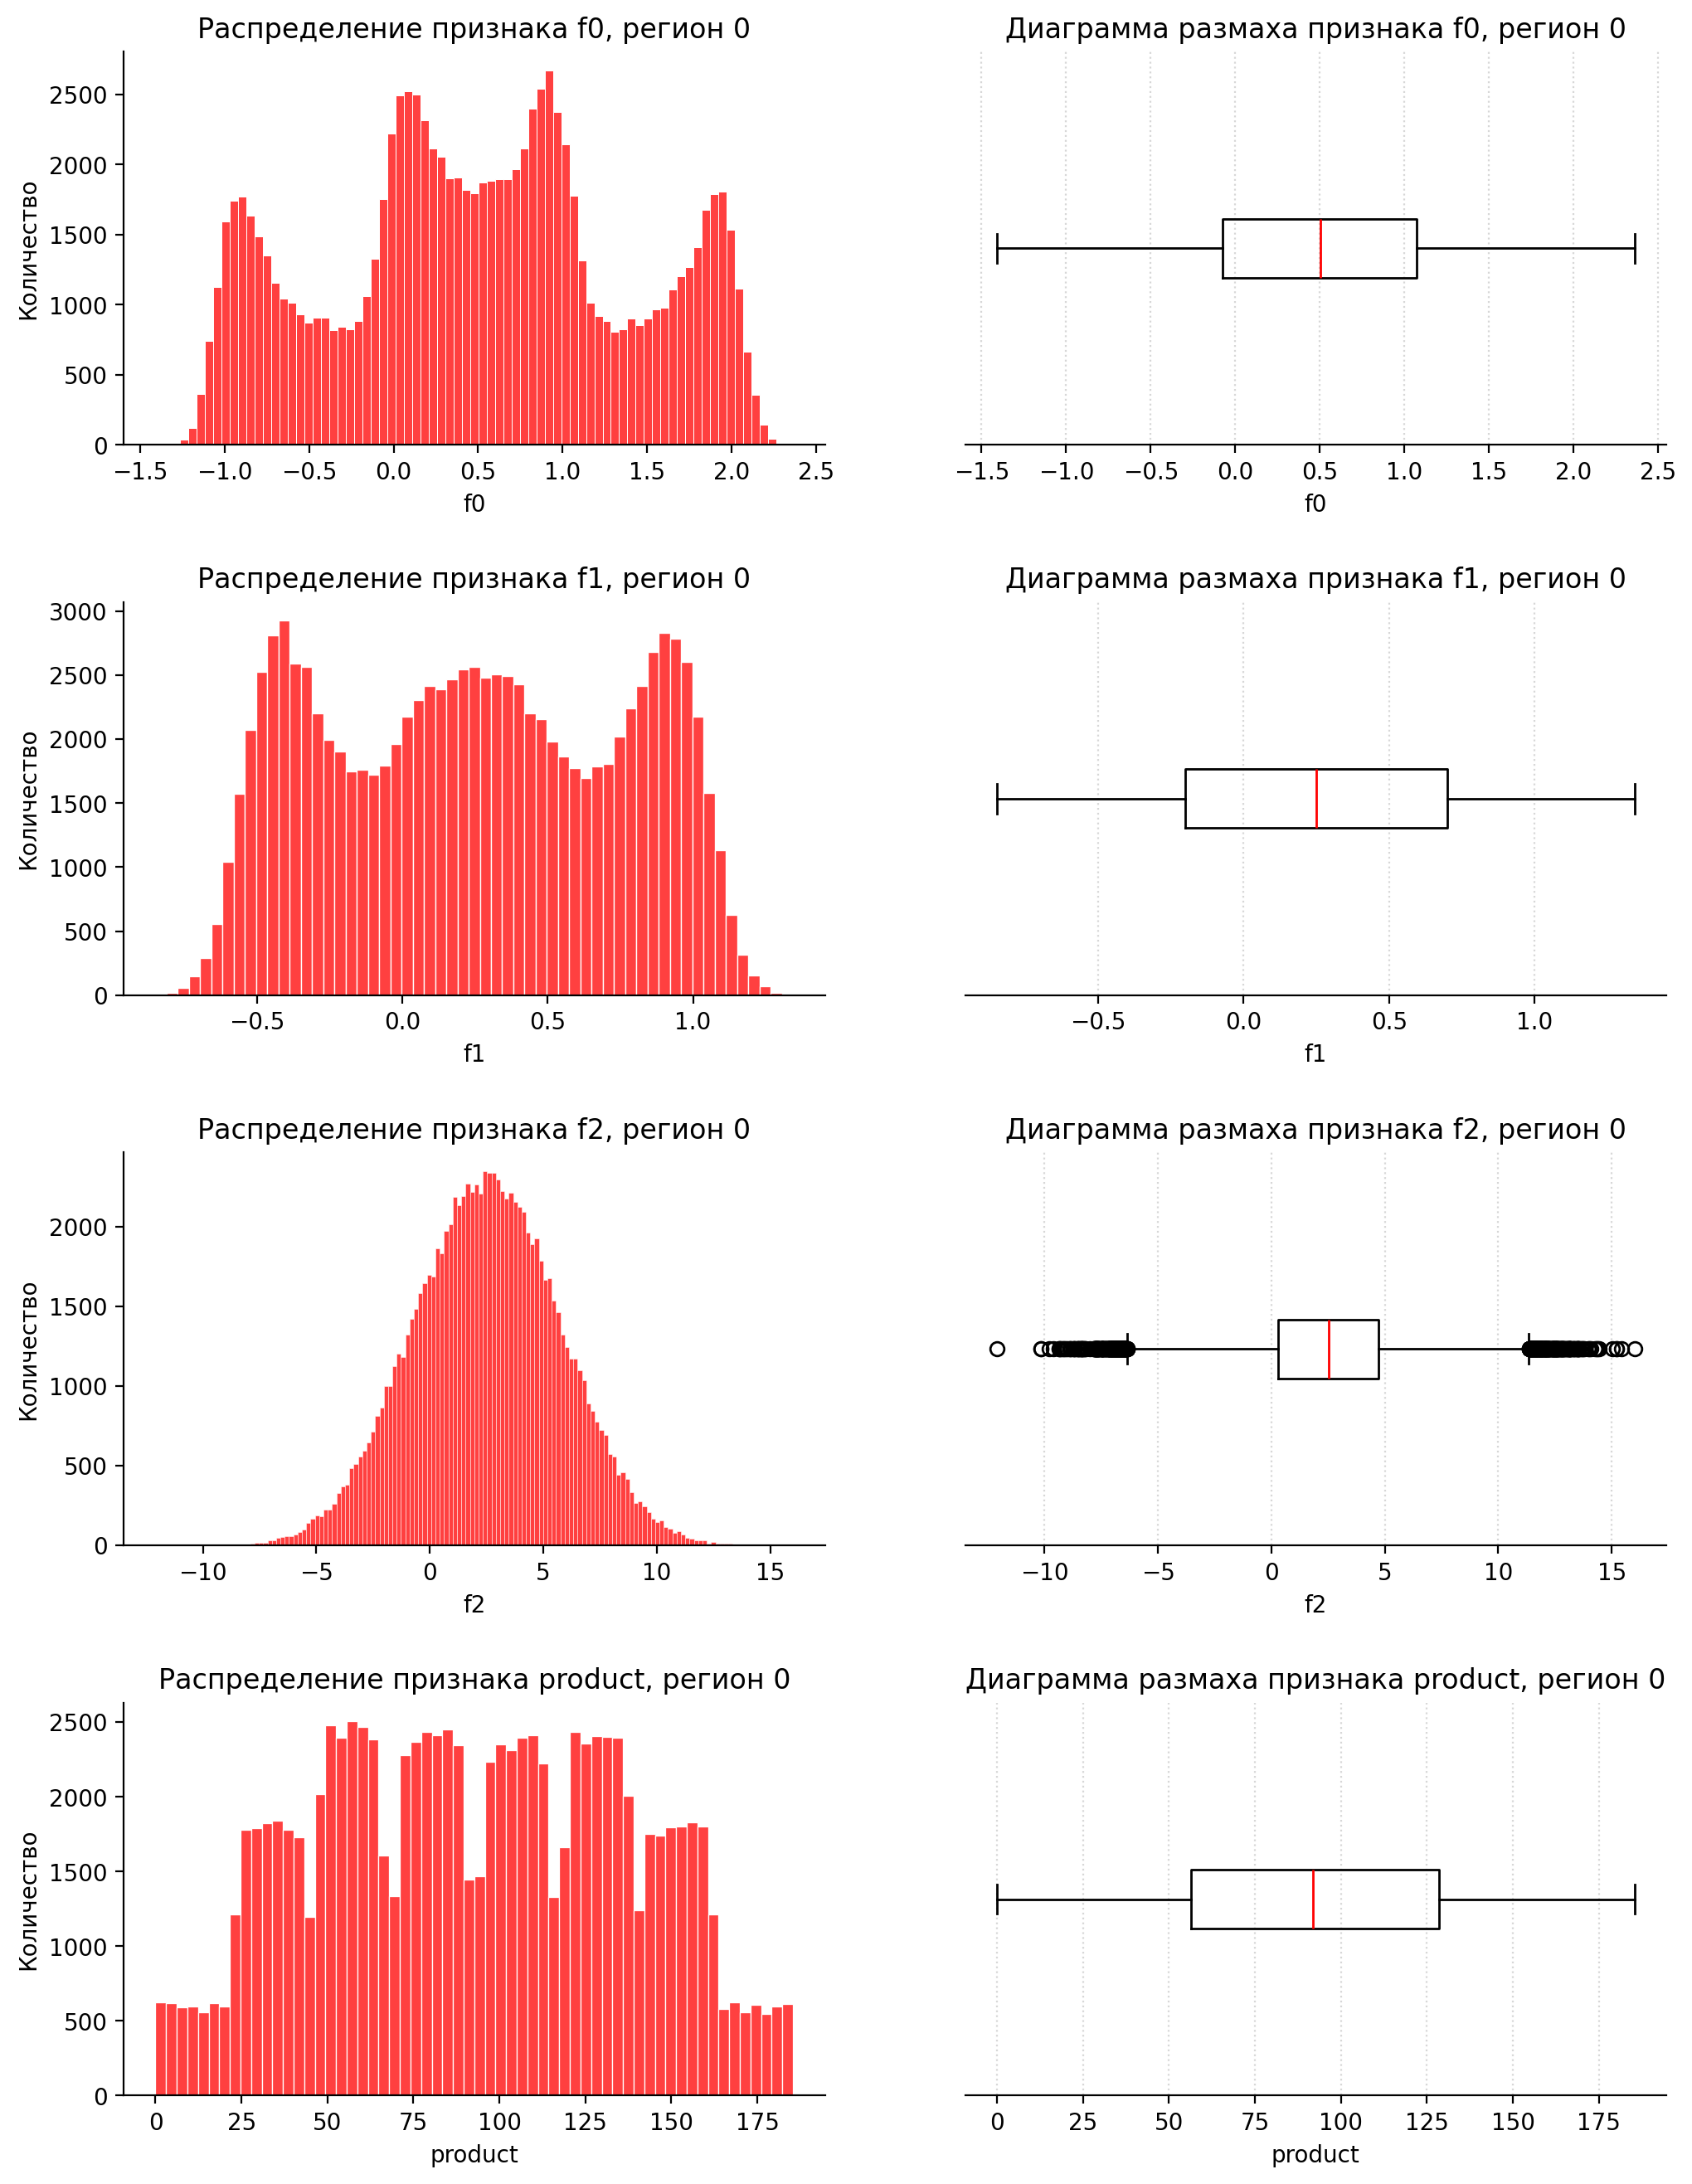

'Регион 1:'

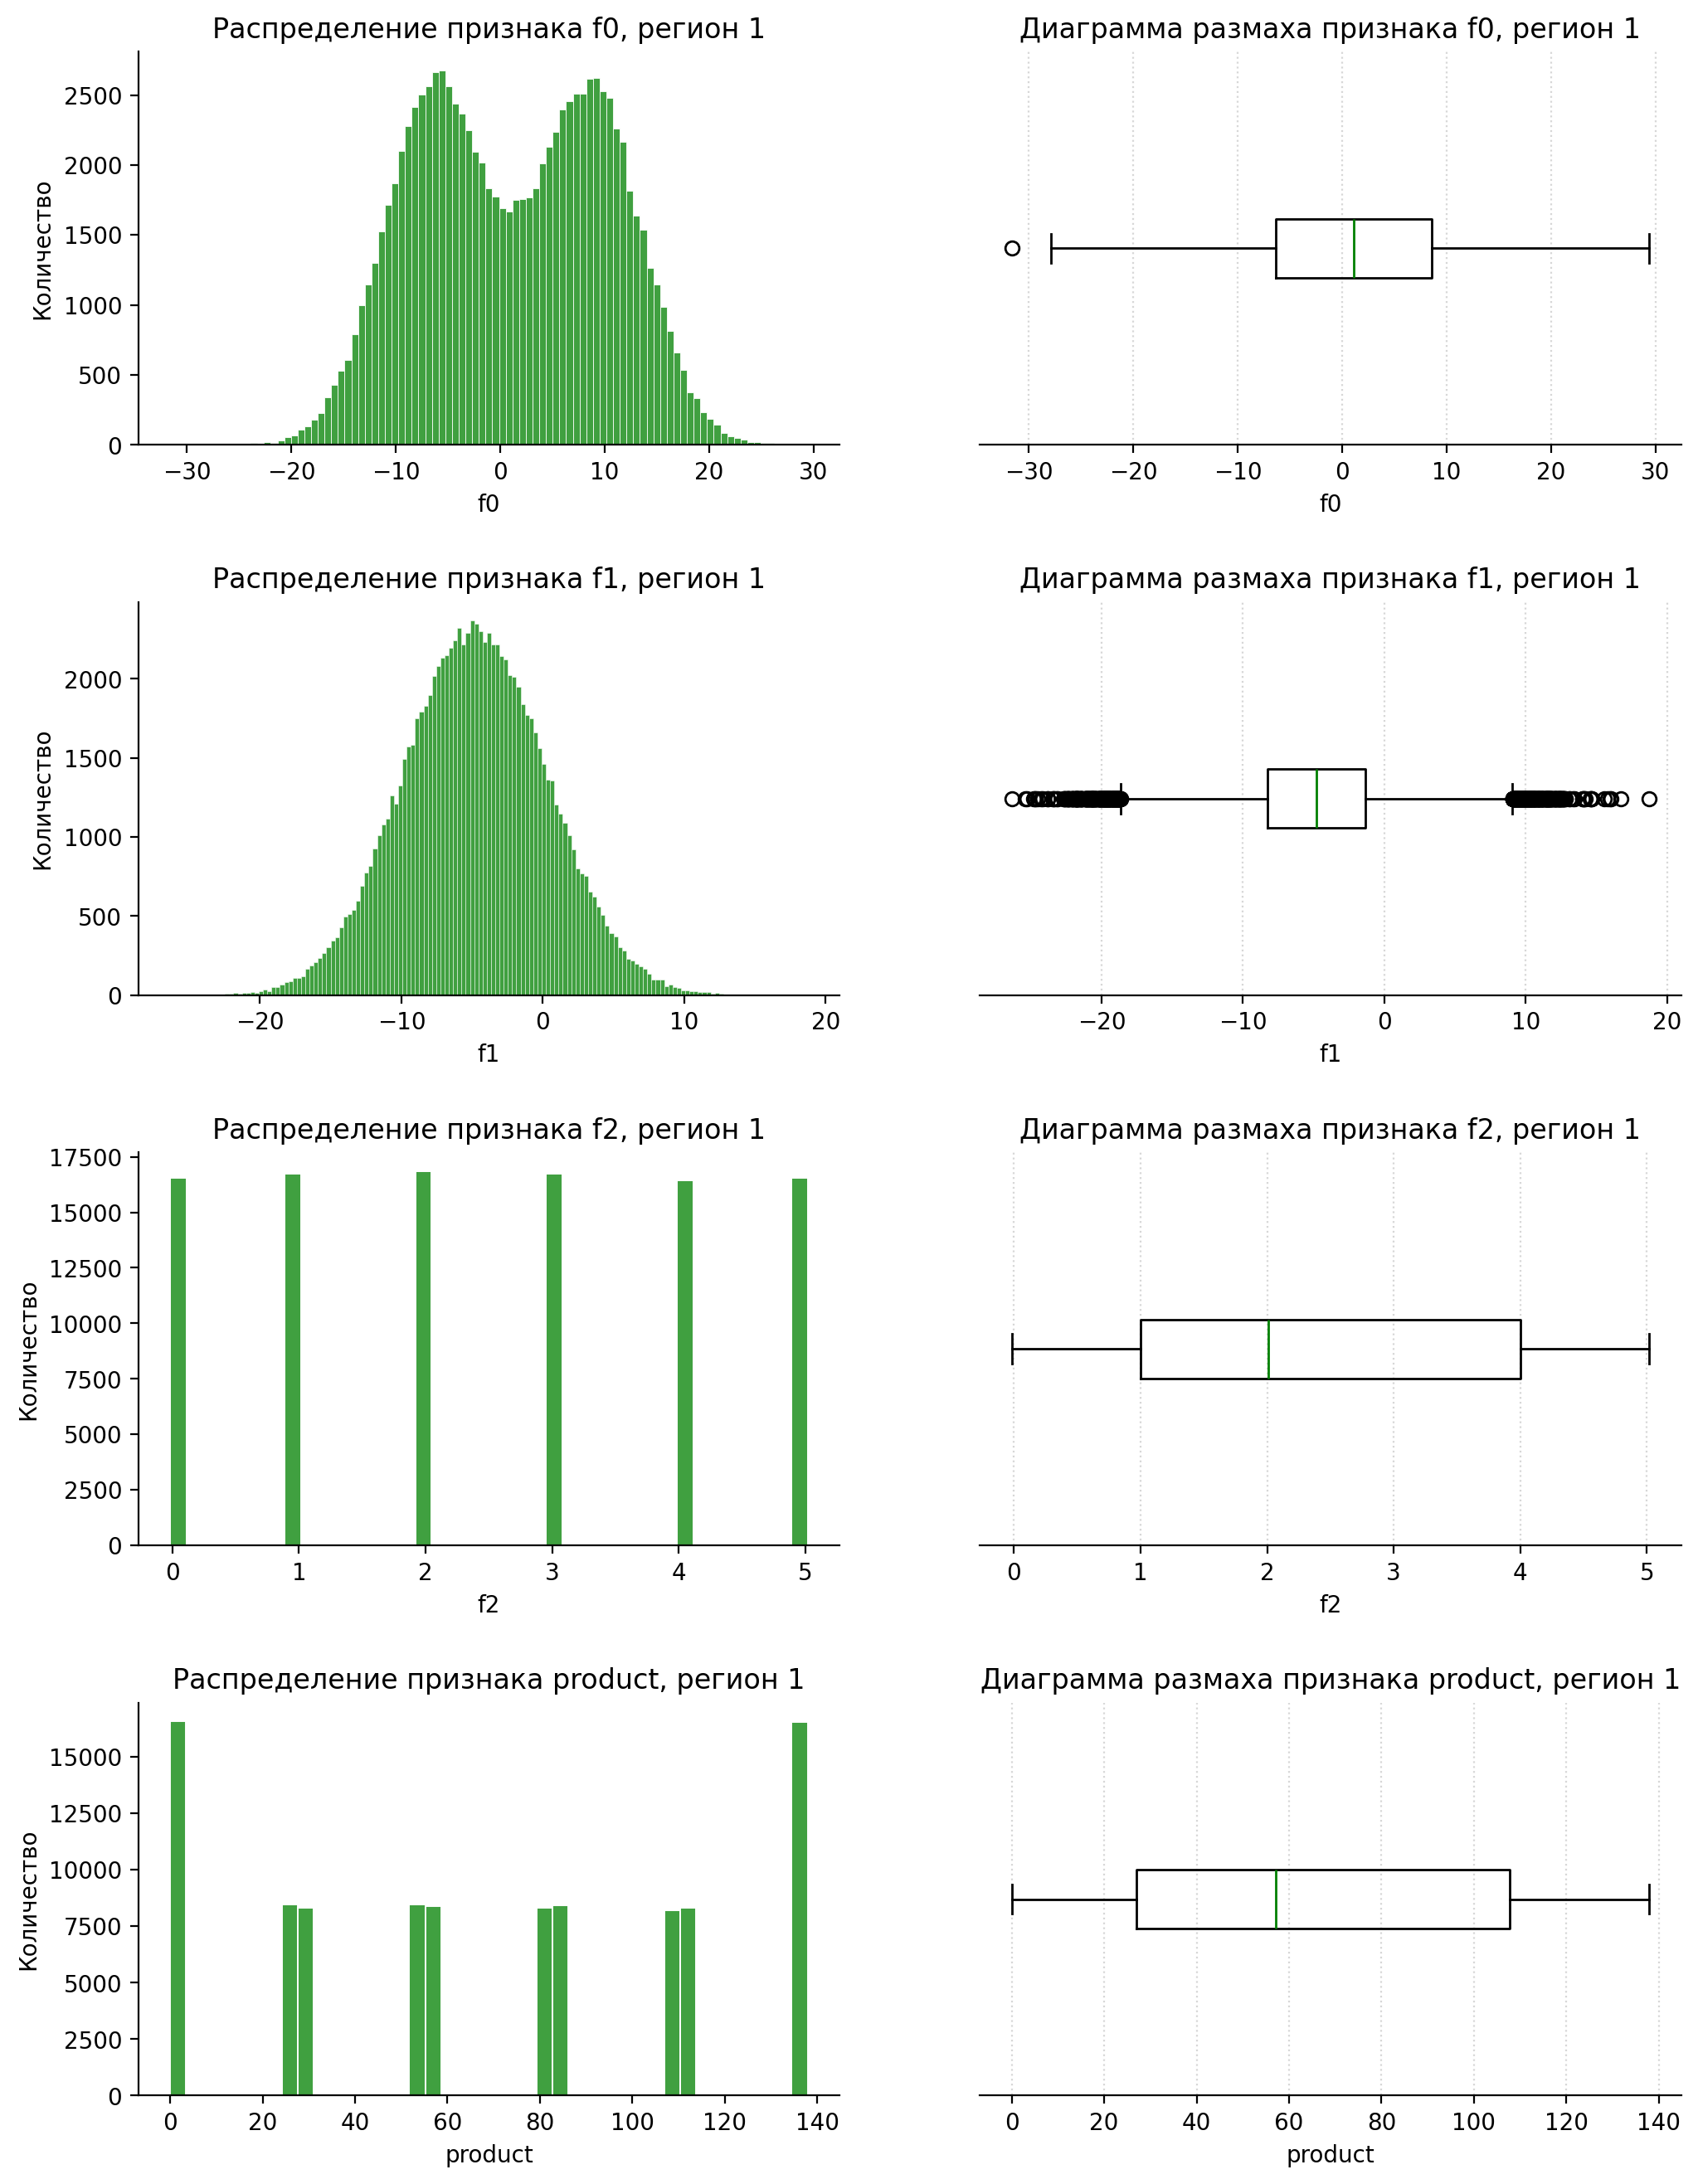

'Регион 2:'

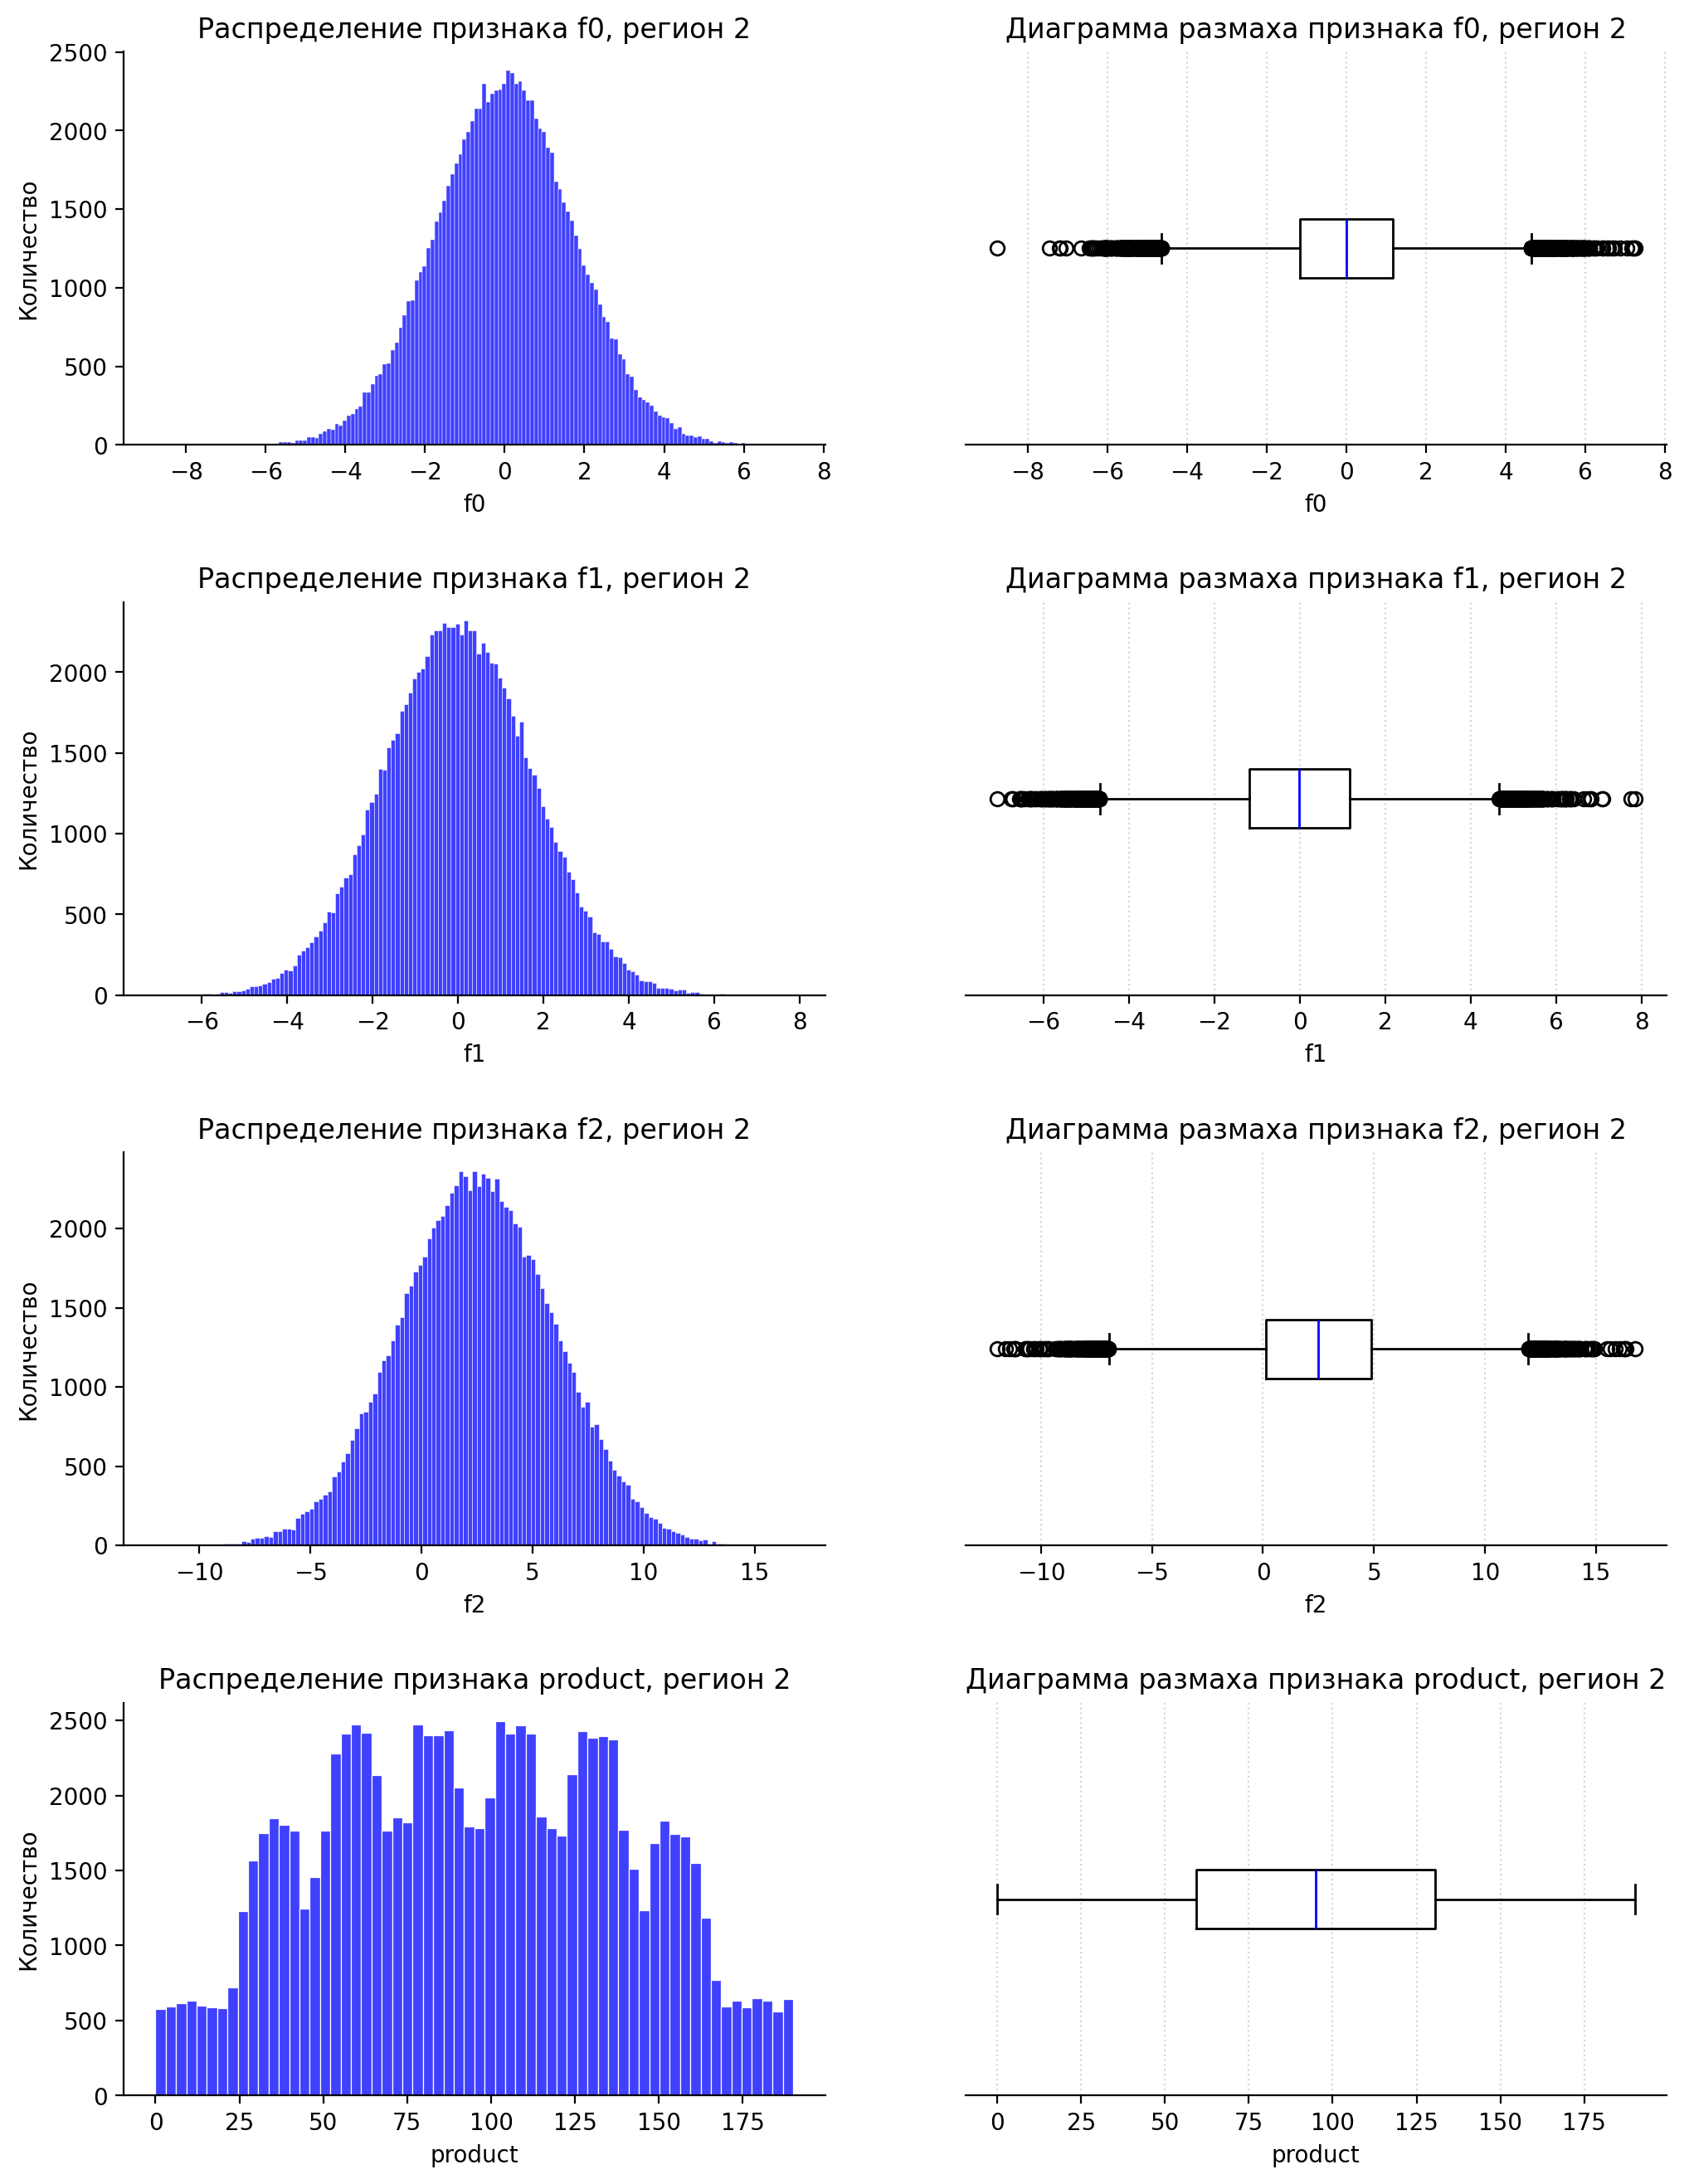

In [25]:
for key, region in enumerate(regions):
    num_col_names = region.select_dtypes(include='number').columns
    
    n = len(num_col_names)
    fig, axes = plt.subplots(n, 2, figsize=(12, n * 4))
    fig.subplots_adjust(hspace=0.4)
    
    for i, col_name in enumerate(num_col_names):
        ax1, ax2 = axes[i, 0], axes[i, 1]
    
        sns.histplot(data=region, x=col_name, ax=ax1, edgecolor='white', color=COLORS[key])
        ax1.set_title(f'Распределение признака {col_name}, регион {key}')
        ax1.set_xlabel(col_name)
        ax1.set_ylabel('Количество')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
    
        region[col_name].plot(kind='box', vert=False, ax=ax2, color='black', medianprops={'color': COLORS[key]})
        ax2.set_title(f'Диаграмма размаха признака {col_name}, регион {key}')
        ax2.set_xlabel(col_name)
        ax2.set_yticklabels([])
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.grid(axis='x', alpha=0.5, linestyle=':')

    display(f'Регион {key}:')
    plt.show()

Рассчитаем коэффициенты корреляции между всеми признаками в датафреймах из списка `regions`. Посмотрим тепловые карты матриц корреляций.

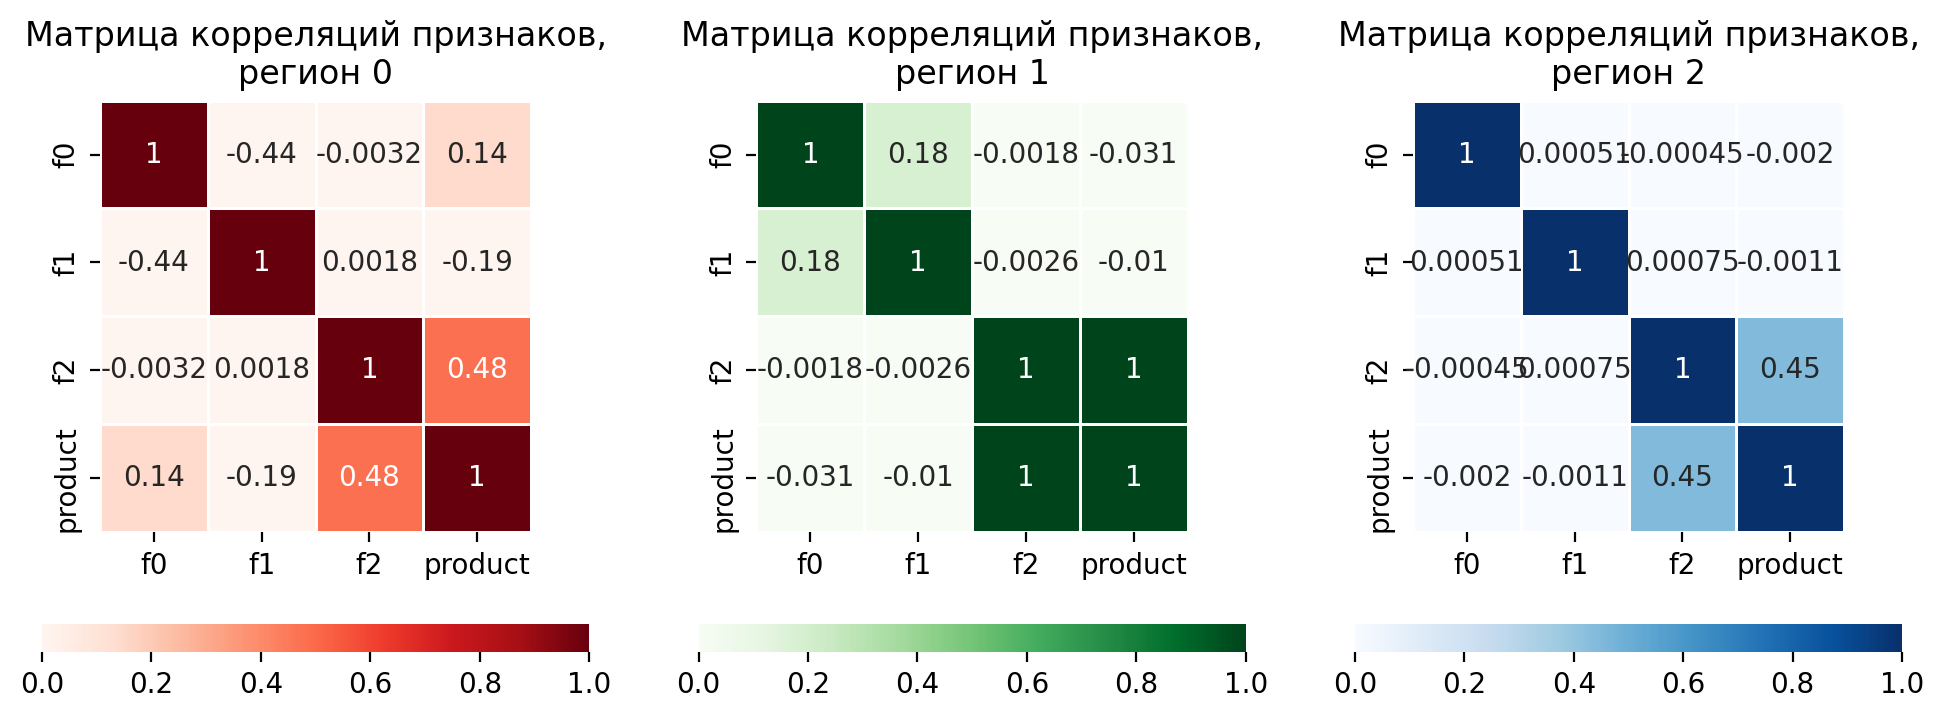

In [27]:
n = len(regions)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

for key, region in enumerate(regions):
    interval_col_names = region.select_dtypes(include='number').columns
    corr_coefficients = region.corr()
    
    sns.heatmap(corr_coefficients, vmin=0, vmax=1, cmap=CMAPS[key], annot=True, linewidths=0.5, 
                cbar=True, cbar_kws={'orientation': 'horizontal'}, square=True, ax=axes[key])
    axes[key].set_title(f'Матрица корреляций признаков,\nрегион {key}')

plt.show()

Мультиколлинеарности, которая может негативно повлиять на качество моделей, не наблюдается. При этом можно отметить, что в регионе 1 весьма высокая связь признака `f2` с целевым признаком `product`.

Посмотрим на диаграммы рассеяния количественных признаков с целевым признаком `product` в датафреймах из списка `regions`.

'Регион 0:'

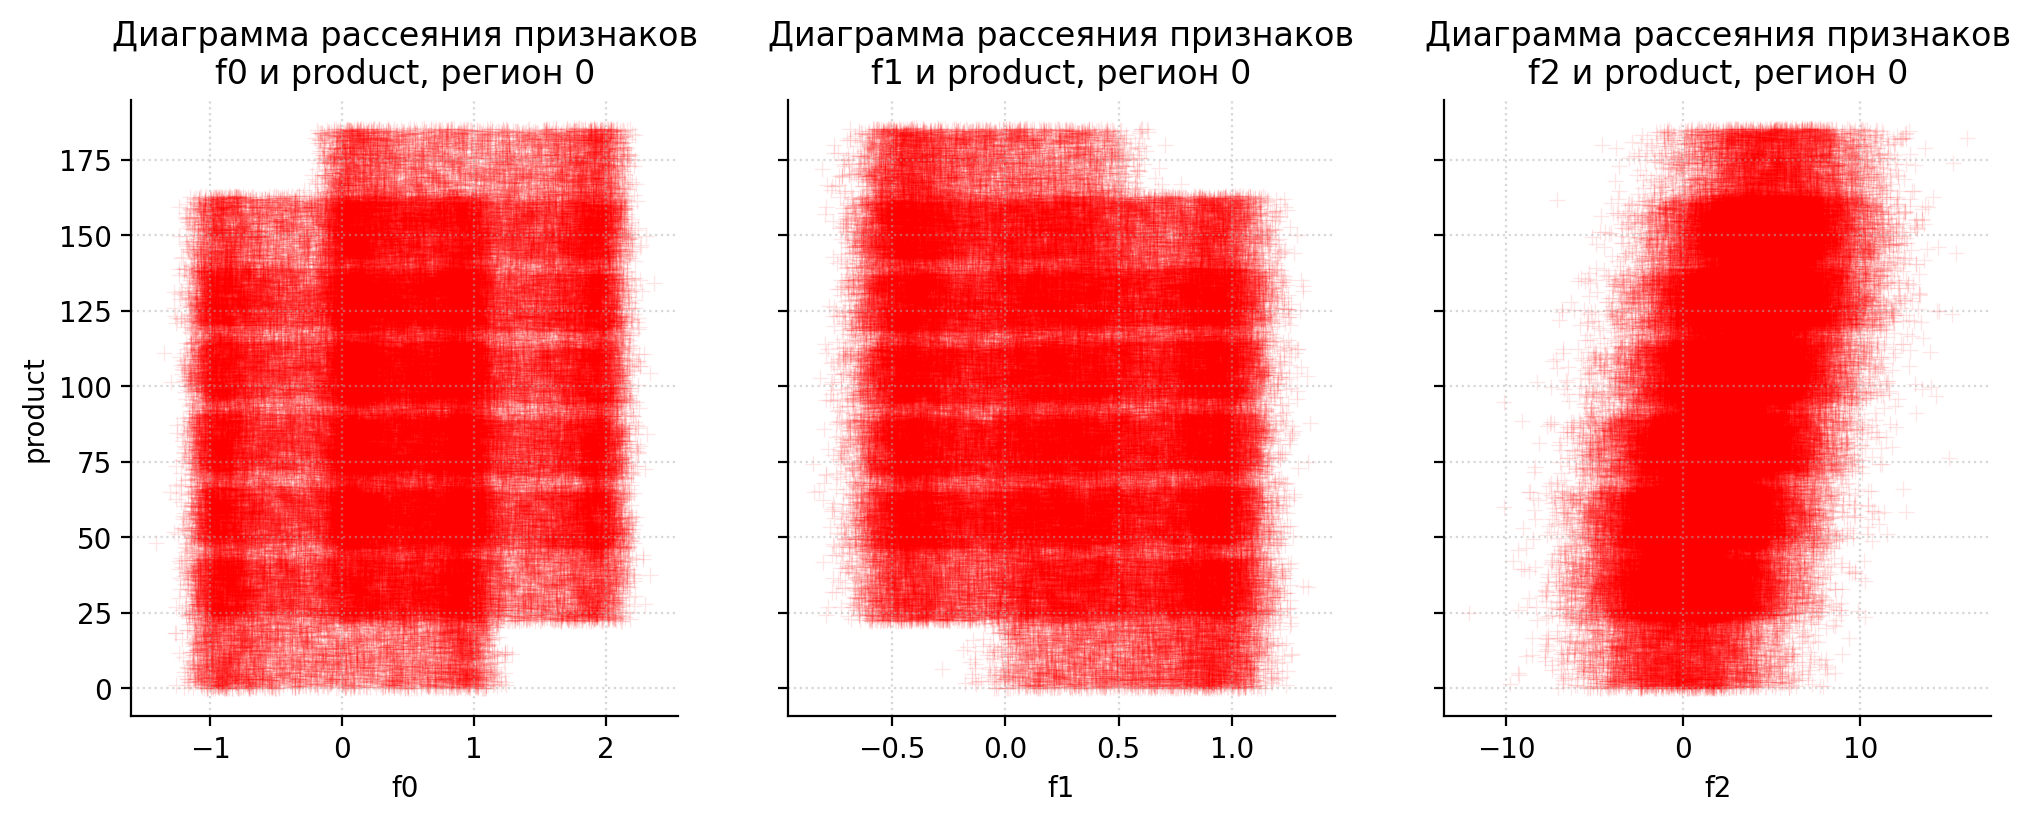

'Регион 1:'

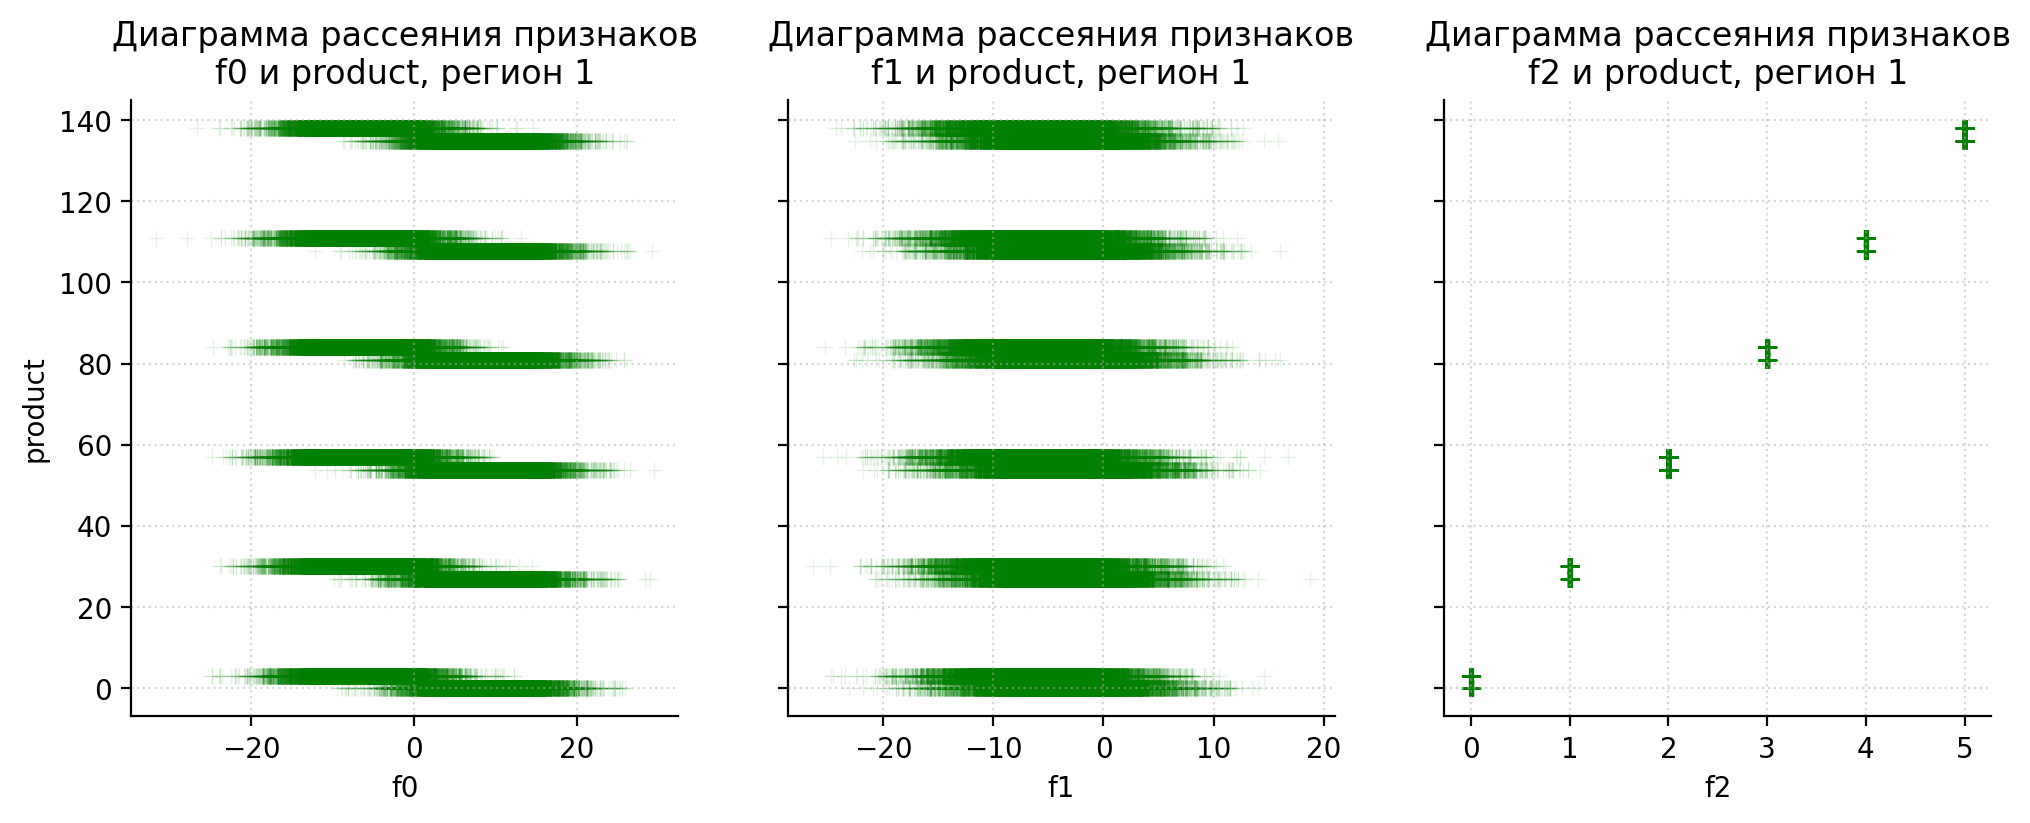

'Регион 2:'

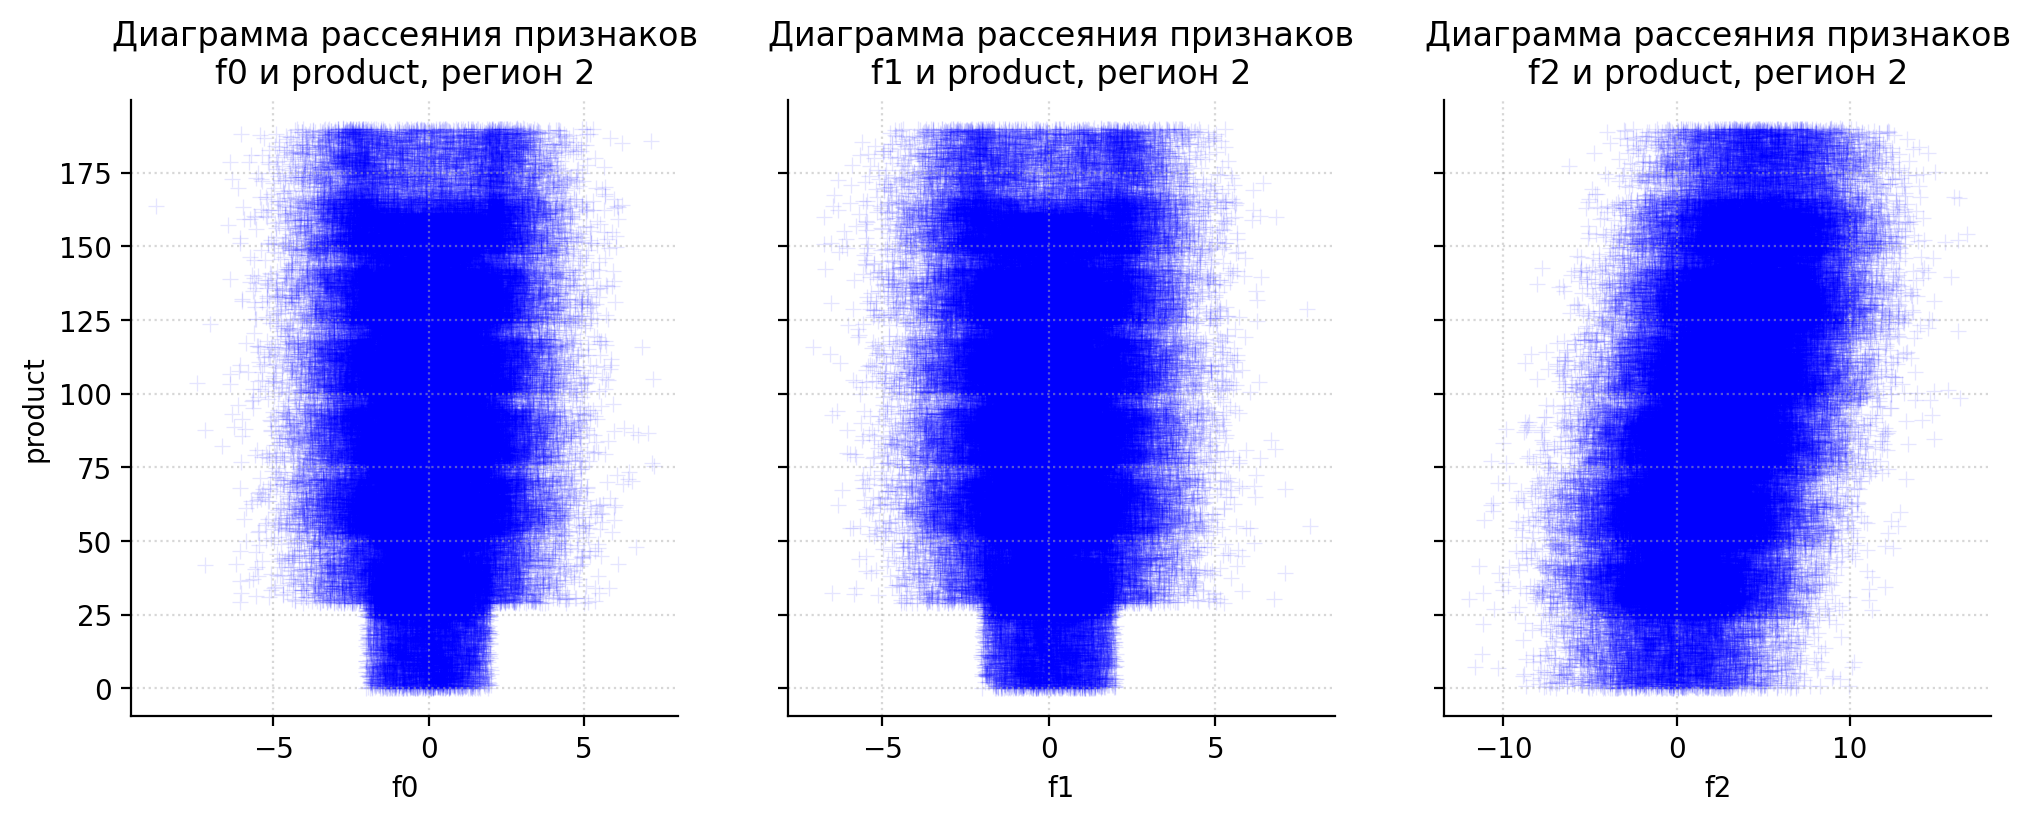

In [30]:
target_col_name = 'product'

for key, region in enumerate(regions):
    num_col_names = region.select_dtypes(include='number').columns.drop(target_col_name)
    
    n = len(num_col_names)
    fig, axes = plt.subplots(1, n, figsize=(n * 4, 4), sharey=True)
    
    for i, col_name in enumerate(num_col_names):
        ax = axes[i]
        
        sns.scatterplot(data=region, x=col_name, y=target_col_name, marker='+', ax=ax, alpha=0.1, color=COLORS[key])
        ax.set_title(f'Диаграмма рассеяния признаков\n{col_name} и {target_col_name}, регион {key}')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(alpha=0.5, linestyle=':')

    display(f'Регион {key}:')
    plt.show()

Можно отметить, что в регионе 1 признак `f2` весьма точно характеризует целевой признак `product`, между ними практически идеальная положительная линейная связь. Это положительно скажется на качестве модели линейной регрессии для региона 1.

## Обучение и проверка модели

Обучим и проверим модель для каждого региона. Сначала подготовим пайплан, включающий `ColumnTransformer` для масштабирования входных признаков и саму модель линейной регрессии.

In [34]:
pipe_preprocessor = ColumnTransformer(
    transformers=[('num', MinMaxScaler(), ['f0', 'f1', 'f2'])], 
    remainder='drop'
)

pipe_final = Pipeline(
    steps=[('preprocessor', pipe_preprocessor),
           ('model', LinearRegression(fit_intercept=True))]
)

Разобъем данные на обучающую и валидационную выборки в соотношении 75:25. Результаты разбиения сохраним в списке `splitted_regions`, который для каждого региона содержит обучающую (ключ `train`) и валидационную выборки (ключ `valid`).

In [36]:
splitted_regions = []
for key, region in enumerate(regions):
    train, valid = train_test_split(region.copy(), test_size=0.25, random_state=RANDOM_STATE)
    splitted_regions.append({'train': train, 'valid': valid})

Обучим модель для каждого региона. Сохраним предсказания на валидационных выборках в столбцах `product_pred`.

In [38]:
for key, splitted_region in enumerate(splitted_regions):  
    X_train = splitted_region['train'].drop('product', axis=1)
    y_train = splitted_region['train']['product']
    X_test = splitted_region['valid'].drop('product', axis=1)
    y_test = splitted_region['valid']['product']

    model = clone(pipe_final)
    model.fit(X_train, y_train)

    splitted_regions[key]['valid']['product_pred'] = model.predict(X_test)

Посмотрим средний запас предсказанного сырья и RMSE модели для каждого региона.

In [40]:
results = pd.DataFrame(columns=['Cредний объём запасов в скважине', 'RMSE модели'])
for key, splitted_region in enumerate(splitted_regions):
    product_mean = splitted_region['valid']['product_pred'].mean()
    rmse_score = mean_squared_error(splitted_region['valid']['product'], 
                              splitted_region['valid']['product_pred'], 
                              squared=False)
    results.loc[f'Регион {key}'] = [product_mean.round(2), rmse_score.round(2)]
results

Cредний объём запасов в скважине  RMSE модели
Регион 0                             92.61        37.69
Регион 1                             68.58         0.89
Регион 2                             94.93        40.08

Как и предполагалось, весьма высокая связь признака `f2` с целевым признаком `product` в регионе 1 положительно сказалась на качестве модели (RMSE=0.89) — корень среднеквадратичной ошибки гораздо ниже, чем у других моделей. При этом модель для региона 1 предсказывает наименьший средний объём запасов в скважинах.

Посмотрим на распределение остатков моделей.

'Регион 0:'

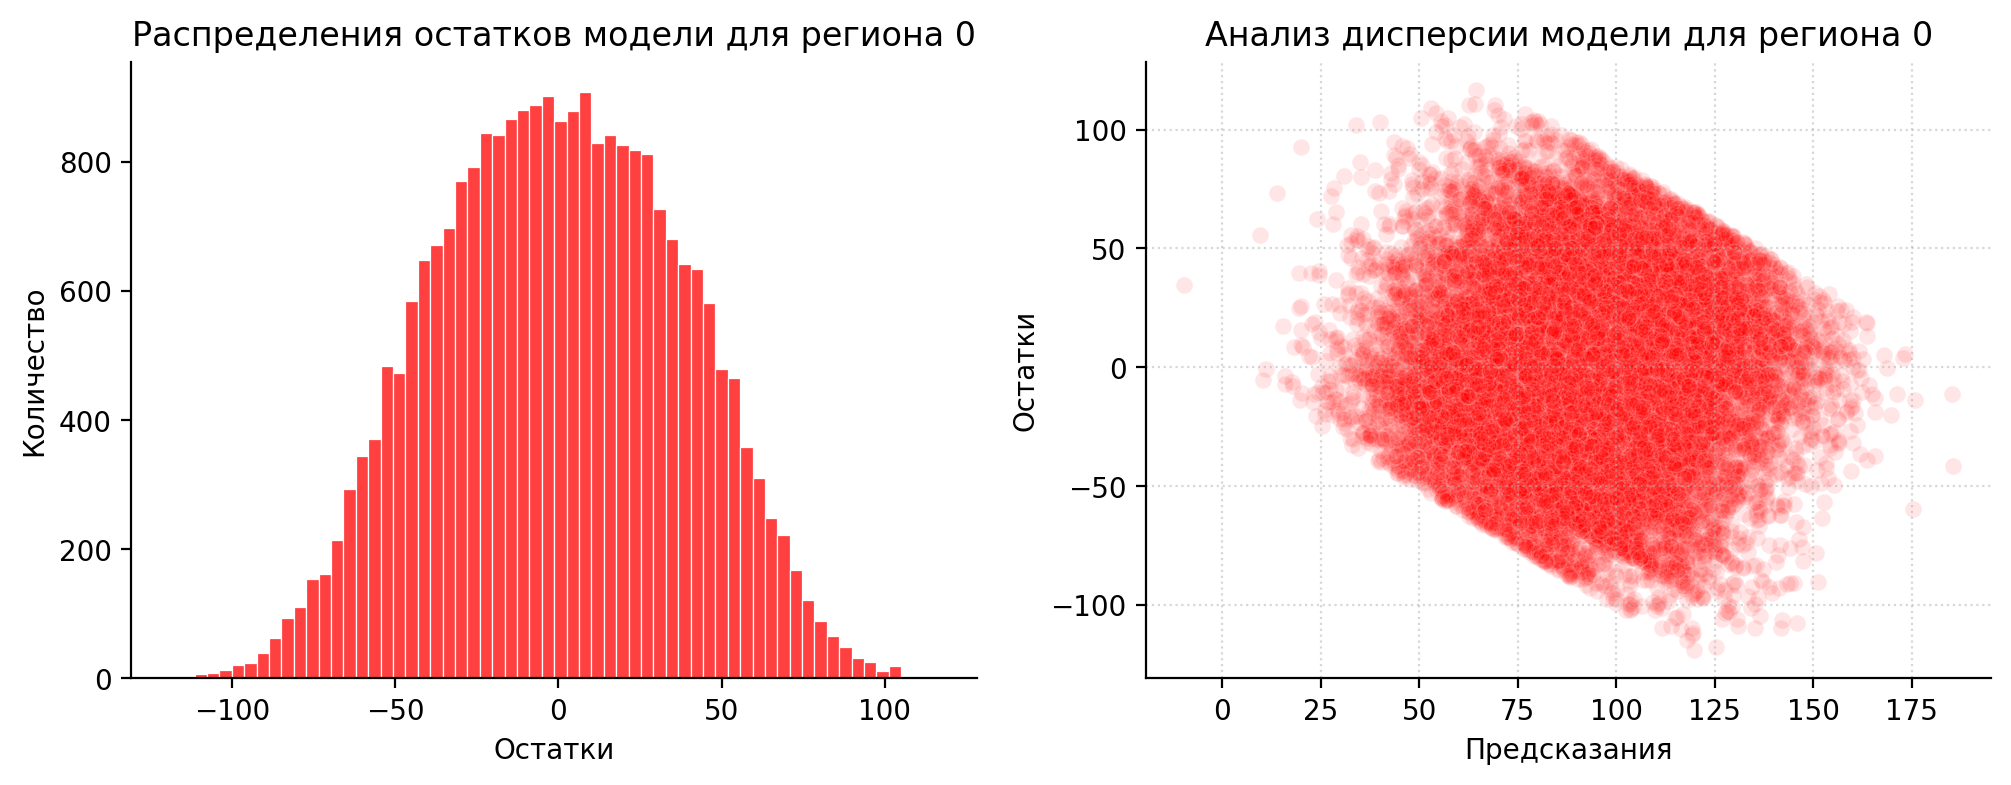

'Регион 1:'

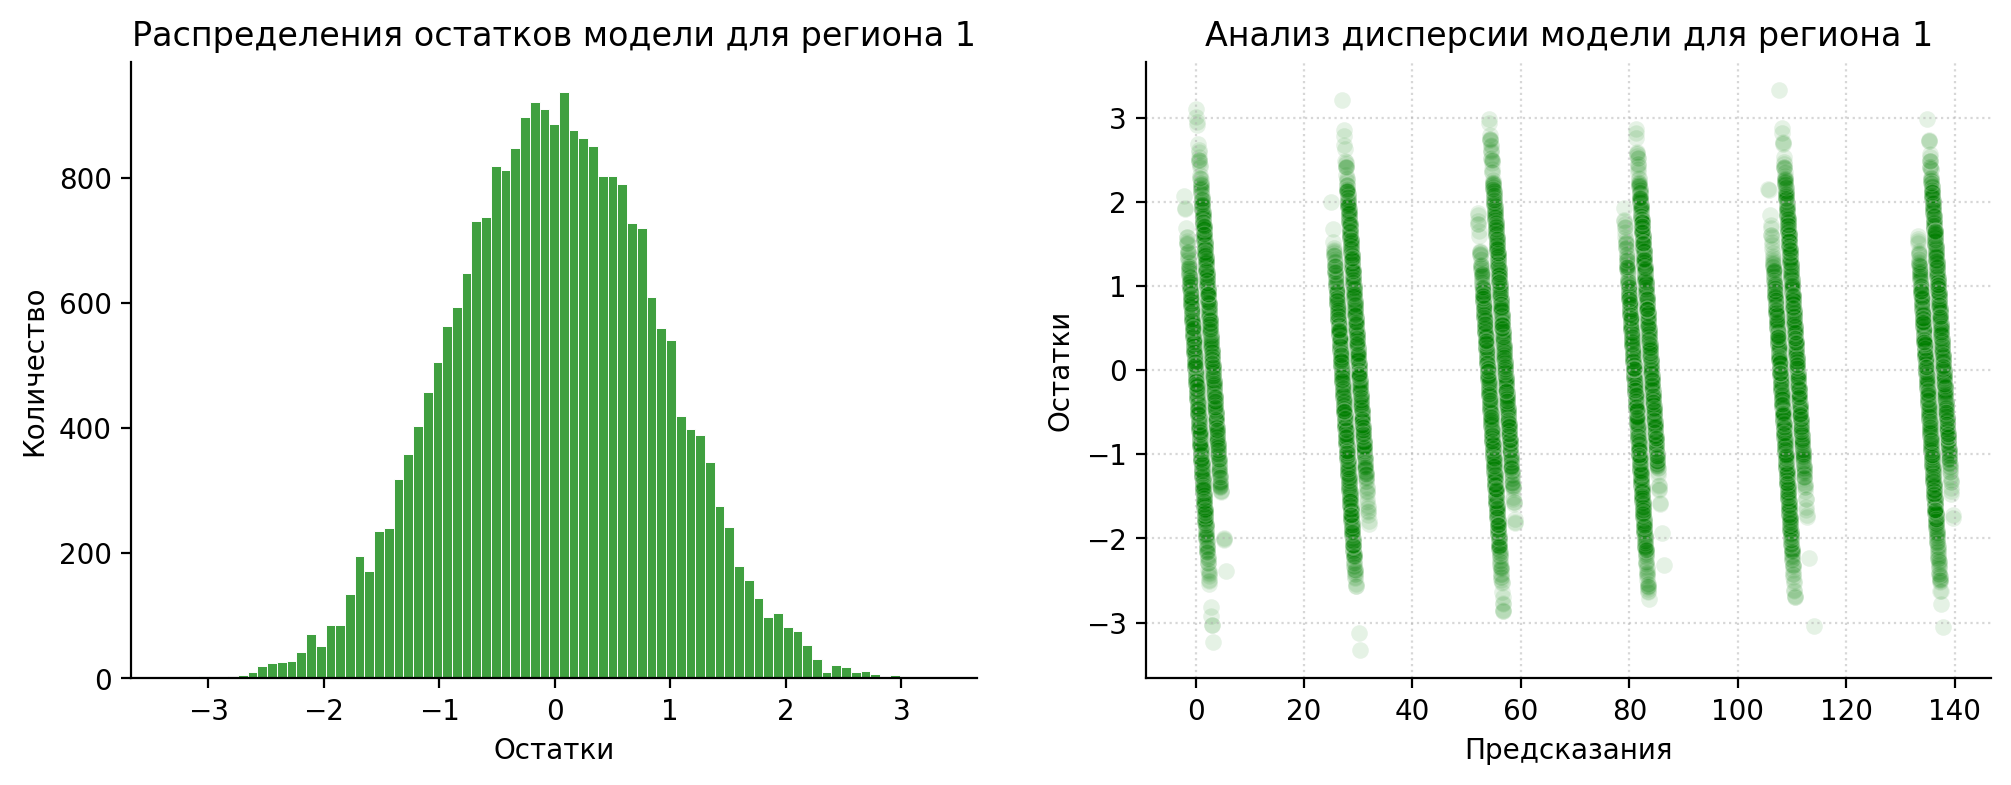

'Регион 2:'

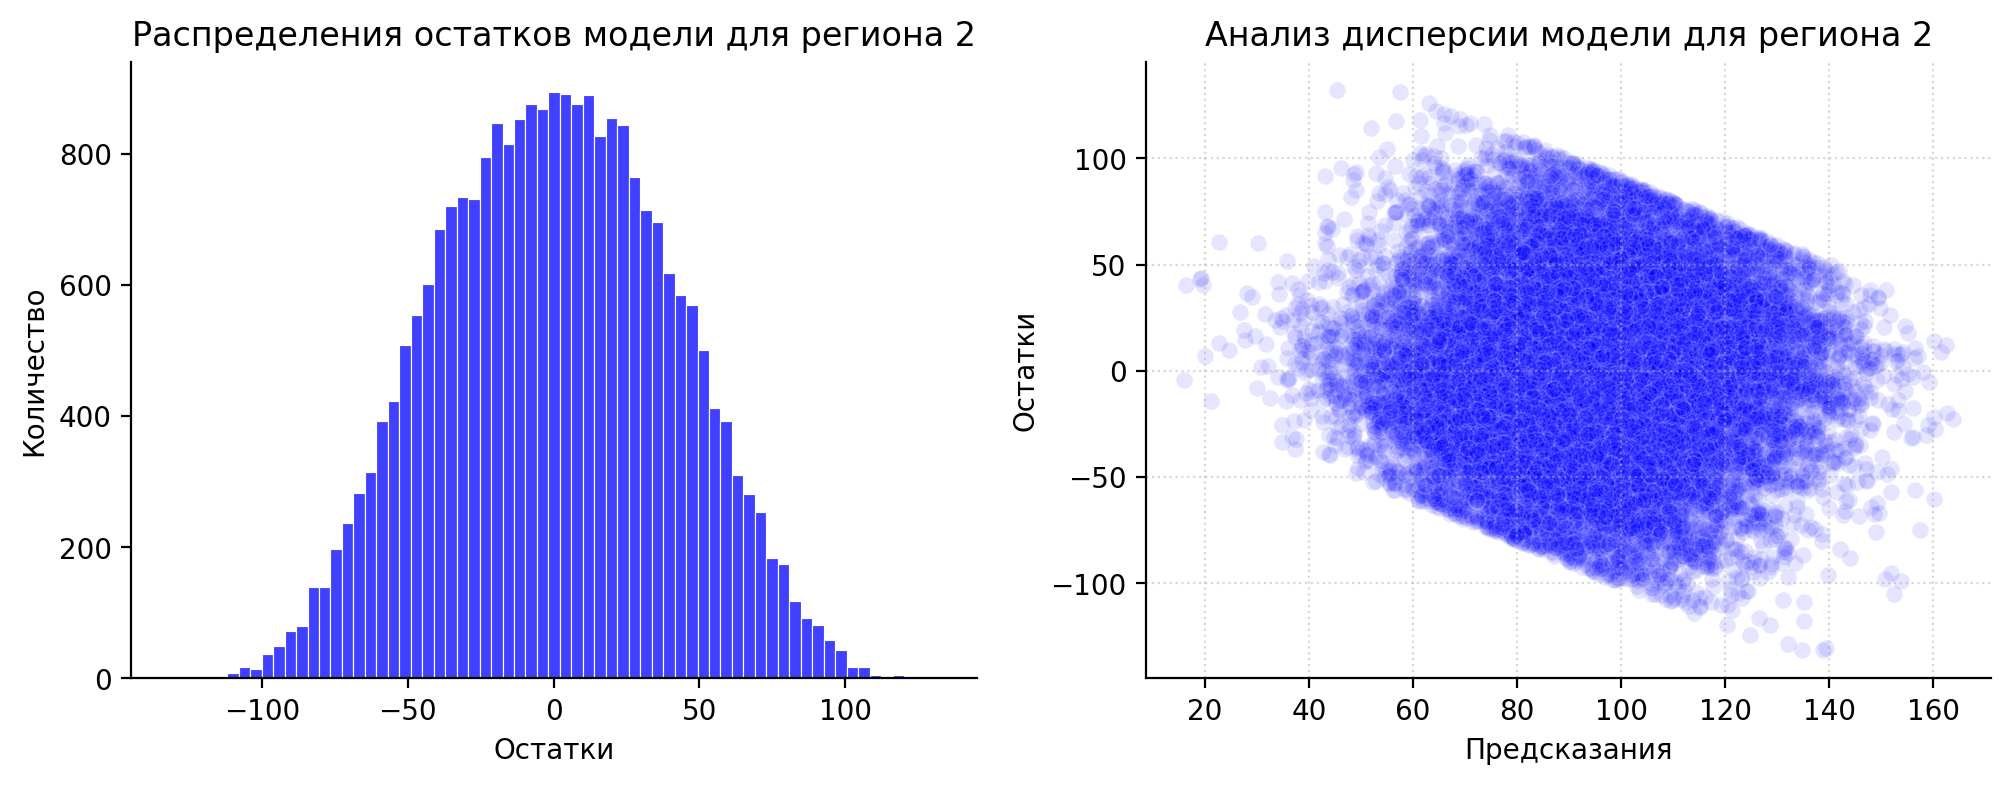

In [43]:
for key, splitted_region in enumerate(splitted_regions):
    residuals = splitted_region['valid']['product'] - splitted_region['valid']['product_pred']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(x=residuals, ax=ax1, edgecolor='white', color=COLORS[key])
    ax1.set_title(f'Распределения остатков модели для региона {key}')
    ax1.set_xlabel('Остатки')
    ax1.set_ylabel('Количество')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    sns.scatterplot(x=splitted_region['valid']['product_pred'], y=residuals, ax=ax2, alpha=0.1, color=COLORS[key])
    ax2.set_title(f'Анализ дисперсии модели для региона {key}')
    ax2.set_xlabel('Предсказания')
    ax2.set_ylabel('Остатки')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.grid(alpha=0.5, linestyle=':')

    display(f'Регион {key}:')
    plt.show()

Остатки всех моделей распределены нормально, со средним около 0. Дисперсия остатков модели 1 наименьшая. Модель 0 и 2 обладают высокой дисперсией остатков, а также занижают предсказания для высоких значений таргета (и завышают предсказания для низких значений таргета).

## Подготовка к расчёту прибыли

Сохраним все ключевые значения для расчётов в отдельных переменных.

In [47]:
ANALYZED_WELLS_COUNT = 500  # при разведке региона исследуют 500 точек
SELECTED_WELLS_COUNT = 200  # с помощью машинного обучения выбирают 200 лучших точек для разработки
BUDGET = 10_000_000_000  # бюджет на разработку скважин в регионе — 10 млрд
PRODUCT_UNIT_PRICE = 450_000  # доход с каждой единицы продукта составляет 450 тыс.
LESS_PROB_THRESHOLD = 0.025  # оставляем лишь те регионы, в которых вероятность убытков меньше 2.5%

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [49]:
break_even_point = BUDGET / SELECTED_WELLS_COUNT / PRODUCT_UNIT_PRICE
round(break_even_point, 2)

111.11

Достаточный объём сырья для безубыточной разработки новой скважины составляет порядка 111 тыс. баррелей, что превышает  средний запас предсказанного сырья в каждом из регионов.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберем скважины с максимальными значениями предсказаний. 
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

In [52]:
def calc_profit(analyzed_wells, selected_wells_count, product_unit_price, budget):
    sorted_wells = analyzed_wells.sort_values(by='product_pred', ascending=False)
    selected_wells = sorted_wells[:selected_wells_count]
    return product_unit_price * selected_wells['product'].sum() - budget

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона, применив технику Bootstrap.

In [55]:
BOOTSTRAP_COUNT = 1000

results = pd.DataFrame(columns=['Средняя прибыль', '95%-й доверительный интервал', 
                                'Вероятность убытков, %', 'Регион подходит'])
for key, splitted_region in enumerate(splitted_regions):
    state = np.random.RandomState(RANDOM_STATE)
    
    profits = []
    for i in range(BOOTSTRAP_COUNT):
        analyzed_wells = splitted_region['valid'].sample(n=ANALYZED_WELLS_COUNT, replace=True, random_state=state)
        profit = calc_profit(analyzed_wells, SELECTED_WELLS_COUNT, PRODUCT_UNIT_PRICE, BUDGET)
        profits.append(profit)
    profits = pd.Series(profits)

    profit_mean = profits.mean()
    profit_lower = profits.quantile(0.025)
    profit_upper = profits.quantile(0.975)
    less_prob = (profits < 0).mean()
    results.loc[f'Регион {key}'] = [int(profit_mean), 
                                    f'{int(profit_lower)} — {int(profit_upper)}',
                                    less_prob * 100,
                                    'да' if less_prob < LESS_PROB_THRESHOLD else 'нет']
results

Средняя прибыль 95%-й доверительный интервал  \
Регион 0        403572063       -137690003 — 902848310   
Регион 1        430208352         43052519 — 847313467   
Регион 2        384214428       -127589876 — 910134439   

          Вероятность убытков, % Регион подходит  
Регион 0                     5.9             нет  
Регион 1                     1.6              да  
Регион 2                     8.0             нет

После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%, — то есть **для разработки скважин предлагается регион 1, в котором вероятность убытков составляет 1.6%**. 

## Общий вывод

В ходе исследования обработаны и проанализированы данные о проббах нефти в трёх регионах. Для каждого региона построены модели, предсказывающие запасы сырья в скважинах. Проанализированы возможная прибыль и риски техникой Bootstrap.

В процессе **предобработки данных** найдено незначительное число пропусков в данных, не повлиявших на дальнейшие исследования.

По результатам **исследовательского анализа данных** можно отметить следующее:
- входные признаки являются непрерывными количественными величинами, часть из них распределены не нормально;
- мультиколлинеарности, которая может негативно повлиять на качество моделей, не обнаружено;
- в регионе 1 весьма высокая связь признака `f2` с целевым признаком `product`.

По результатам **обучения и проверки моделей**, предсказывающих запасы сырья в скважинах, можно отметить следующее:
- модель для региона 1 обладает лучших качеством по метрике RMSE — корень среднеквадратичной ошибки гораздо ниже, чем у других моделей других регионов.
- наименьший средний объём запасов в скважинах предсказан для региона 1.

**Расчет рисков и прибыли** для каждого региона с применением техники Bootstrap позволил **выбрать регион 1 для разработки месторождения**. Показатели региона 1:
- средняя прибыль — 430 208 352;
- 95%-й доверительный интервал — от 43 052 519 до 847 313 467;
- вероятность убытков — 1.6%.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован